In [1]:
"""Importing All The Required Packages"""
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble, tree
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate
from sklearn.metrics import confusion_matrix, auc,roc_auc_score,roc_curve,recall_score,classification_report
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)

In [2]:
"""Function To Load The Data"""

def Load_File(path) :
    if os.path.isfile(path) :
        data = pd.read_csv(path)
        print("\n" + "Number of rows in data are %s" % len(data))
        print("Number of columns in data are %s" % len(data.columns) + "\n")
        print("Following are the data types of columns:- ")
        print(data.dtypes)
        print("Number of missing values in the data are:- ")
        print(data.isnull().sum())
        print("Data Import is Complete")
        
        return data
    else:
        print(path + " does not exist. Enter the correct path")

"""Function to encode the categorical data"""
def categorical_encoding(df, column_name):
    print(df[column_name].unique())
    categorical_columns = pd.get_dummies(df[column_name], prefix = column_name, prefix_sep = '_', drop_first = False)
    df = pd.concat([df, categorical_columns], axis = 1)
    df = df.drop(column_name, axis = 1)
    return df

In [3]:
### Importing Data

data = Load_File('takehome_data.csv')


Number of rows in data are 30000
Number of columns in data are 8

Following are the data types of columns:- 
funnel_search_id       object
created_at             object
tasker_id               int64
position                int64
hourly_rate             int64
num_completed_tasks     int64
hired                   int64
category               object
dtype: object
Number of missing values in the data are:- 
funnel_search_id       0
created_at             0
tasker_id              0
position               0
hourly_rate            0
num_completed_tasks    0
hired                  0
category               0
dtype: int64
Data Import is Complete


In [4]:
### Removing Funnel Search Id. As this only meant like a unique identifier it won't be of much he

data = data.drop('funnel_search_id', axis = 1)

In [5]:
### In this step, I am creating features from the timestamp. I believe part of the day can have impact on the 
### selection of tasker. So i will bin the data using hours and then split it into different parts.

data['created_at']  = pd.to_datetime(data['created_at'])
data['Hour_Of_Day'] = data['created_at'].dt.hour    ## Hour of the day for recommendation
data['Weekday']     = data['created_at'].dt.weekday ## Weekday from date. Monday is 0 and Sunday is 6

### Binning for Part of the day whether the report was during Morning, Evening or Night

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
data['Part_Of_Day']  = pd.cut(data['Hour_Of_Day'], bins=b, labels=l, include_lowest=True)
data['Day_Of_Month'] = data['created_at'].dt.day

data = data[['tasker_id', 'position', 'hourly_rate', 'num_completed_tasks',
            'category', 'Hour_Of_Day', 'Part_Of_Day', 'Day_Of_Month', 'Weekday', 'hired']]

In [6]:
### We can see that there are duplicates in the data. Check index 1075 and 1120. So we need to remove duplicates

data[data['tasker_id'] == 1006892359].head(100)

,tasker_id,position,hourly_rate,num_completed_tasks,category,Hour_Of_Day,Part_Of_Day,Day_Of_Month,Weekday,hired
1,1006892359,2,40,193,Furniture Assembly,0,Late Night,1,4,0
72,1006892359,2,40,193,Furniture Assembly,1,Late Night,1,4,0
255,1006892359,5,40,193,Furniture Assembly,14,Noon,1,4,0
271,1006892359,6,40,193,Furniture Assembly,14,Noon,1,4,0
526,1006892359,6,40,194,Furniture Assembly,17,Eve,1,4,0
620,1006892359,7,40,195,Furniture Assembly,19,Eve,1,4,0
708,1006892359,5,51,196,Mounting,21,Night,1,4,0
853,1006892359,5,40,196,Furniture Assembly,23,Night,1,4,0
1029,1006892359,4,51,196,Mounting,11,Morning,2,5,0
1075,1006892359,5,51,197,Mounting,12,Morning,2,5,0


In [7]:
### Removing Duplicates From Data

data = data.drop_duplicates()

In [8]:
### Filter Out the data for hired only

data_hired = data[data['hired']==1]

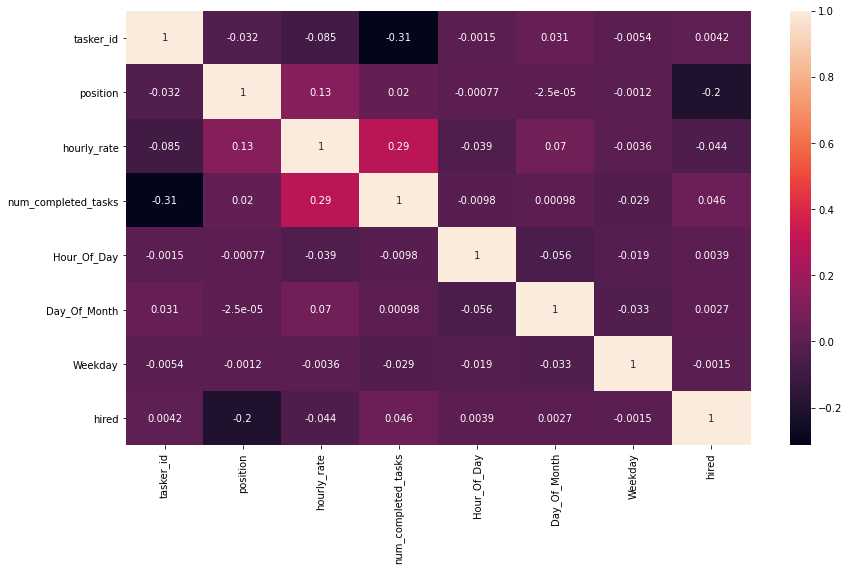

In [9]:
### Using Heatmap we will check for correlation in the data. We can see that there is not much correlation between
### two features. Maximum is between the columns num_completed_task and hourly rate which is understandable.

plt.figure(figsize=(14, 8))
sns.heatmap(data.corr(), annot=True)

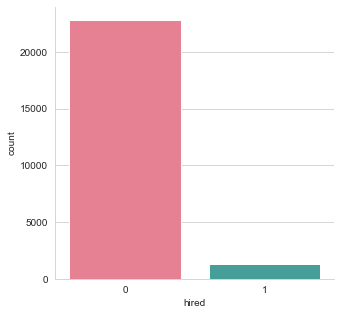

In [10]:
### We can see that data is imbalanced when it comes to hired vs not hired. This is a CLASS IMBALANCE PROBLEM

plt.figure(figsize = (5, 5))
sns.set_style("whitegrid")
sns.countplot('hired', data=data, palette='husl', order = data['hired'].value_counts().index)
sns.despine()

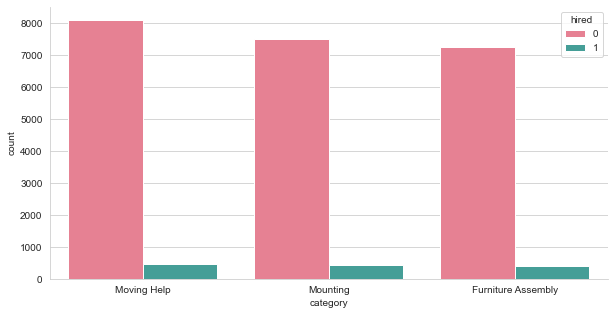

In [11]:
### This plot shows us hired in each different category. We can see that in every category hired are very less
### as compared to not hired.

plt.figure(figsize = (10, 5))
sns.set_style("whitegrid")
sns.countplot('category', data=data, palette='husl', hue = 'hired', order = data['category'].value_counts().index)
sns.despine()

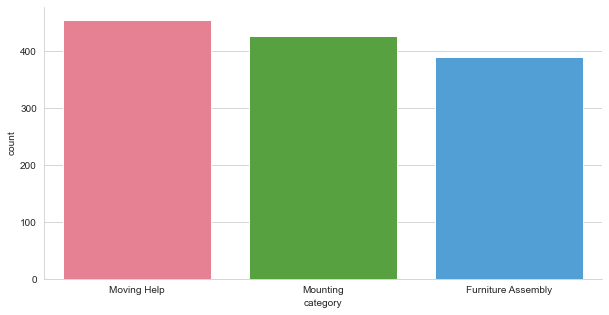

In [12]:
### This plot shows us the number of hired taskers by CATEGORY and we can see that there is not nuch difference between
### three.

plt.figure(figsize = (10, 5))
sns.set_style("whitegrid")
sns.countplot('category', data=data_hired, palette='husl', order = data_hired['category'].value_counts().index)
sns.despine()

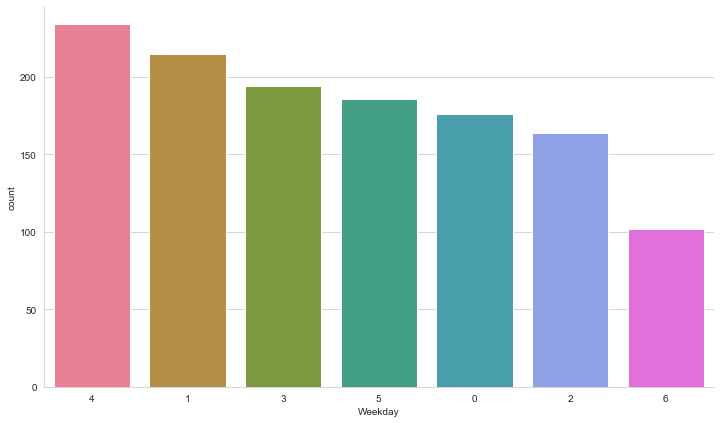

In [13]:
### We can see that Most of the hired taskers are on Friday (4). We can see that we have the least number of hired
### tasker on Sunday (6). So this can impact the final output of our model.

plt.figure(figsize = (12, 7))
sns.set_style("whitegrid")
ax = sns.countplot('Weekday', data=data_hired, palette='husl', order = data['Weekday'].value_counts().index)
sns.despine()


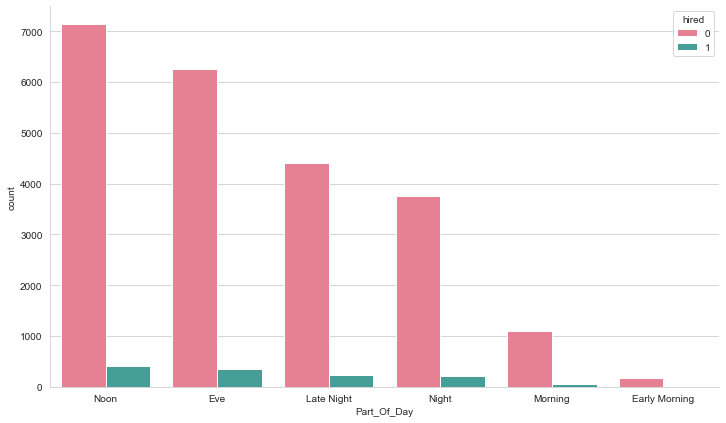

In [14]:
### This plot shows us the most of hiring happens from Noon to Night. This depends on the timezone as well. As I don't
### have the information related to timezone, I am assumming that data is for same timezone only. From the below plot
### we can see that part of the day has significant impact on the whether a person is hired or not

plt.figure(figsize = (12, 7))
sns.set_style("whitegrid")
sns.countplot('Part_Of_Day', data=data, palette='husl', hue = 'hired', order = data['Part_Of_Day'].value_counts().index)
sns.despine()

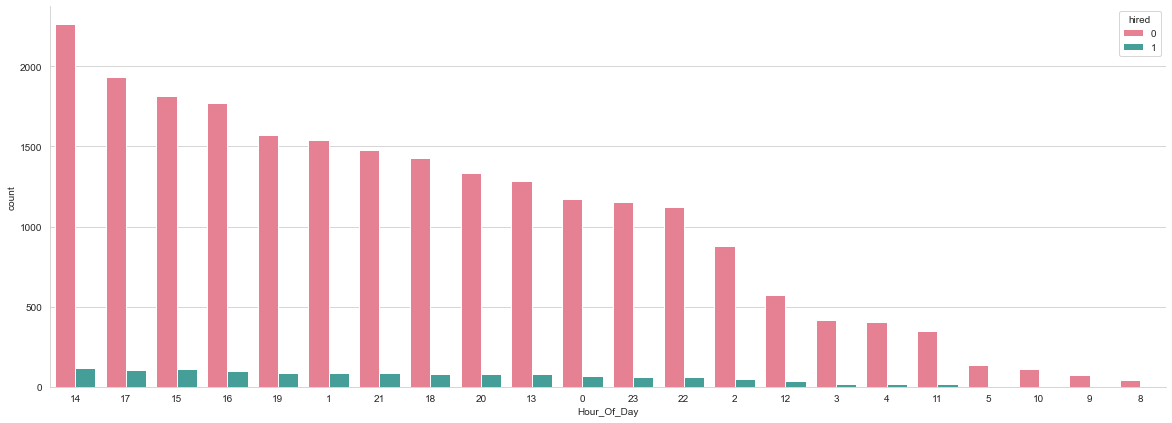

In [15]:
### This plot shows us the data by hour of the day and this is complimenting the plot from above.

plt.figure(figsize = (20, 7))
sns.set_style("whitegrid")
sns.countplot('Hour_Of_Day', data=data, palette='husl', hue = 'hired', order = data['Hour_Of_Day'].value_counts().index)
sns.despine()

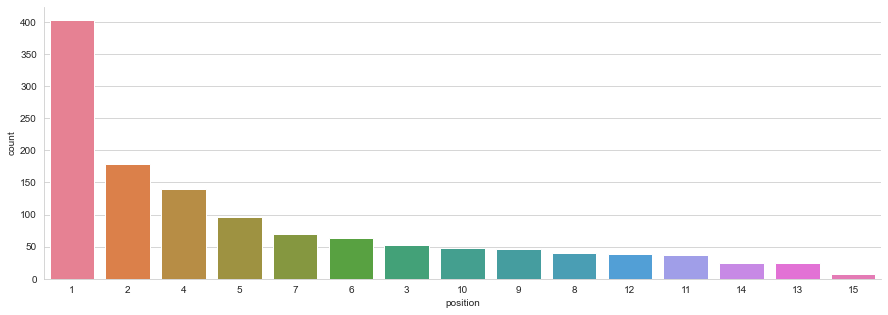

In [16]:
### This plot shows us the hired taskers by position only. We can see from this plot that position of recommendation
### has significant impact on whether someone can get hired or not. Position 1 has the most number of hired taskers
### and that keeps on decreasing with the position

plt.figure(figsize = (15, 5))
sns.set_style("whitegrid")
sns.countplot('position', data=data_hired, palette='husl', order = data_hired['position'].value_counts().index)
sns.despine()

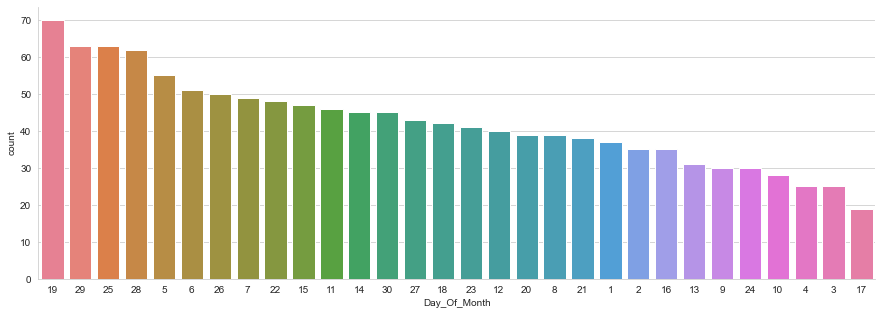

In [17]:
plt.figure(figsize = (15, 5))
sns.set_style("whitegrid")
sns.countplot('Day_Of_Month', data=data_hired, palette='husl', order = data_hired['Day_Of_Month'].value_counts().index)
sns.despine()

In [18]:
data_hired

,tasker_id,position,hourly_rate,num_completed_tasks,category,Hour_Of_Day,Part_Of_Day,Day_Of_Month,Weekday,hired
12,1009856900,13,50,914,Furniture Assembly,0,Late Night,1,4,1
24,1009856900,10,50,914,Furniture Assembly,0,Late Night,1,4,1
32,1011985968,3,32,0,Moving Help,0,Late Night,1,4,1
48,1009114267,4,95,1053,Moving Help,0,Late Night,1,4,1
81,1009072269,11,35,59,Furniture Assembly,1,Late Night,1,4,1
...,...,...,...,...,...,...,...,...,...,...
29902,1013760262,1,40,85,Furniture Assembly,22,Night,30,5,1
29951,1014508755,5,50,147,Moving Help,22,Night,30,5,1
29962,1008980036,1,35,306,Furniture Assembly,22,Night,30,5,1
29986,1007303362,10,60,223,Mounting,23,Night,30,5,1


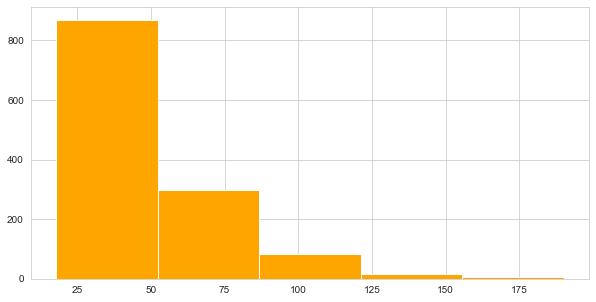

In [19]:
### This plot is from the data for hired people only. We can see from the histogram that most of the hired taskers
### have their hourly rate between 18 and 50 which is evident as they are the taskers which most of people can afford
### those. As the hourly rate increases number of hired taskers dropped.

plt.figure(figsize = (10, 5))
sns.set_style("whitegrid")
data_hired['hourly_rate'].hist(color='orange', bins = 5)

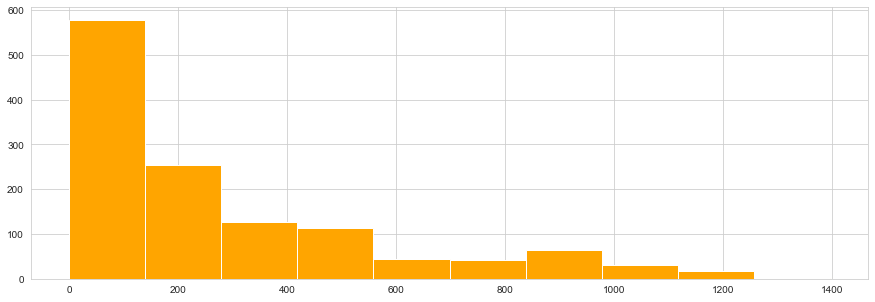

In [20]:
### We can see from this plot that most of the hired taskers completed tasks between 0 and 300. There may be several
### other reasons which impact this. From this we can see that as the number_of_tasks increases, hired taskers are
### decreasing which doesn't make much sense. 

plt.figure(figsize = (15, 5))
sns.set_style("whitegrid")
data_hired['num_completed_tasks'].hist(color='orange', bins = 10)

(array([[12661.,  4312.,  1783.,  1469.,   575.,   692.,   531.,   492.,
           277.,    47.],
        [13242.,  4563.,  1909.,  1582.,   619.,   739.,   594.,   518.,
           295.,    49.]]),
 array([   0. ,  140.6,  281.2,  421.8,  562.4,  703. ,  843.6,  984.2,
        1124.8, 1265.4, 1406. ]),
 <a list of 2 Lists of Patches objects>)

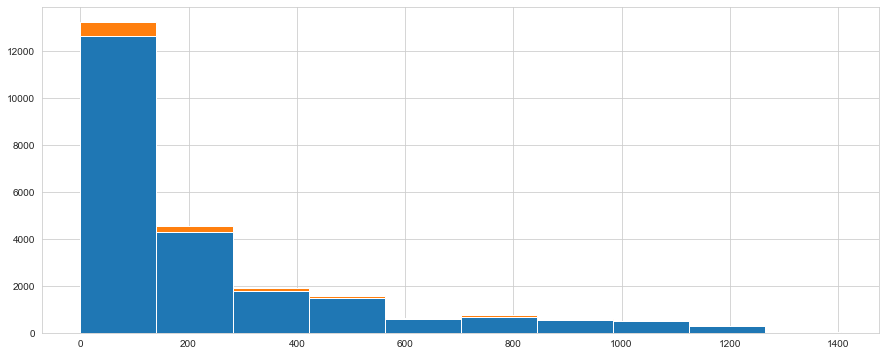

In [21]:
### From this plot we can see that we have most of the data where NUM_COMPLETED_TASKS is less in number. Therefore
### above plot makes sense. As for that particular range, we have more data, so it is expected to have more taskers
### for less number of tasks completed. To validate this claim we need more data.

plt.figure(figsize = (15, 6))
sns.set_style("whitegrid")
plt.hist([data[data['hired']==0]['num_completed_tasks'],
          data_hired['num_completed_tasks']], 
         stacked=True)

In [22]:
### Encoding the Categorical Features

data = categorical_encoding(data, 'category')
data = categorical_encoding(data, 'Part_Of_Day')

['Furniture Assembly' 'Moving Help' 'Mounting']
[Late Night, Noon, Eve, Night, Morning, Early Morning]
Categories (6, object): [Late Night < Early Morning < Morning < Noon < Eve < Night]


In [23]:
### We do not have any other information about the tasker. TASKER_ID is a unique identifier for tasker which solely
### doesn't make difference to the decision. Other information for the tasker like age, gender, height etc would have 
### been beneficial to the model

manipulated_data = data.drop(['tasker_id'], axis = 1)

In [24]:
### Here we will split the data into features and target

feature = manipulated_data.drop(['hired'], axis = 1)
target  = manipulated_data['hired']

In [25]:
### Here we will split our data into training and testing. As we have less data, I will keep 80% of the data for 
### training and only 20% for testing. I would like to have more data where I can create three separate datasets
### for training, validation and testing. As our objective here is to find features which impact the decision whether
### tasker is hired or not, I will use most for training only.

X_train, X_test, Y_train, Y_test = train_test_split(feature, target, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify=manipulated_data.hired)

In [26]:
### As data is very imbalanced, I will use SMOTE which is Synthetic Minority Oversampling Technique and this will
### oversample the data to make both the clasees balanced

smote = SMOTE(random_state=123, k_neighbors=50)
X_Smote_Train, Y_Smote_Train = smote.fit_sample(X_train, Y_train)

In [27]:
### We can see that after oversampling we have equal number of both categories.

Y_Smote_Train.value_counts()

1    18271
0    18271
Name: hired, dtype: int64

In [28]:
### Here I will be using Random Forest Model

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=123)

In [29]:
random_forest_model.fit(X_Smote_Train, Y_Smote_Train)

RandomForestClassifier(random_state=123)

In [30]:
predictions_random = random_forest_model.predict(X_test)

In [31]:
confusion_matrix(Y_test, predictions_random)

array([[4475,   93],
       [ 201,   53]])

In [32]:
### We can see that our model is performing good on the CLASS == 0 which is expected.

print(classification_report(Y_test, predictions_random, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4568
           1       0.36      0.21      0.27       254

    accuracy                           0.94      4822
   macro avg       0.66      0.59      0.62      4822
weighted avg       0.93      0.94      0.93      4822



In [33]:
### Creating a dataframe for Feature Importance

importance = pd.concat([pd.DataFrame(X_Smote_Train.columns),
                          pd.DataFrame(np.transpose(random_forest_model.feature_importances_))], axis = 1)
importance.columns = ['Features', 'Coeff']
importance = importance.sort_values('Coeff', ascending=False)

In [34]:
importance

,Features,Coeff
0,position,0.205784
2,num_completed_tasks,0.109326
1,hourly_rate,0.081171
3,Hour_Of_Day,0.076393
7,category_Mounting,0.062950
6,category_Furniture Assembly,0.062848
12,Part_Of_Day_Noon,0.062101
13,Part_Of_Day_Eve,0.060607
8,category_Moving Help,0.059074
4,Day_Of_Month,0.054991


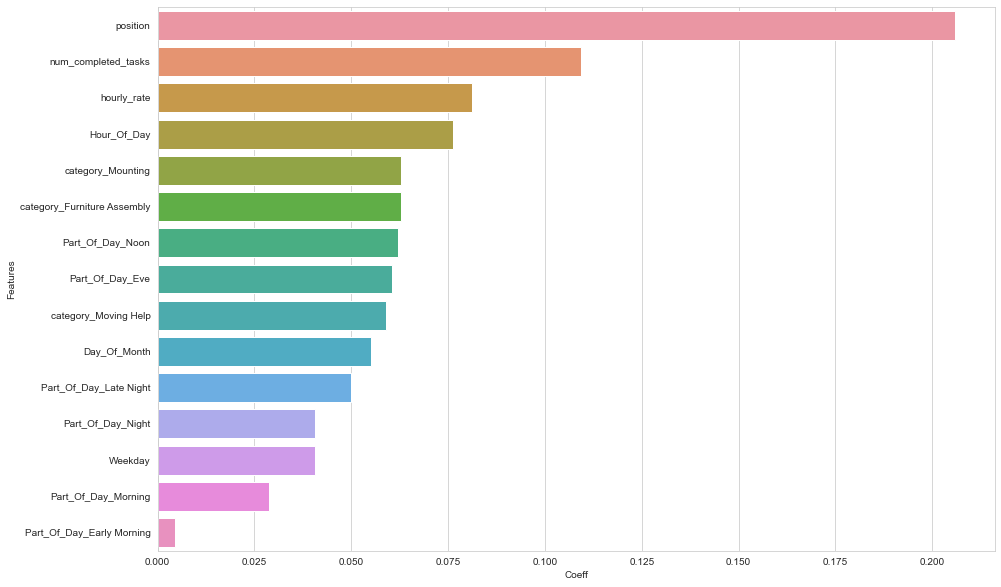

In [35]:
### This plot shows us the importance of Features. We predicted these features to be important from the EDA as well
### We can clearly see that POSITION, NUM_COMPLETED_TASKS, AND HOURLY_RATE are the three most important features
### and this is what we predicted from Exploring the data as well. 
### Least responsible feature for the decision of hiring is category based on the data. 

"""TOP 5 FEATURES ARE :-
1. POSITION
2. NUM_COMPLETED_TASKS
3. HOURLY_RATE
4. HOUR_OF_DAY
5. DAY_OF_MONTH
6. WEEKDAY
"""

plt.figure(figsize = (15, 10))
sns.set_style("whitegrid")
sns.barplot(importance['Coeff'], importance['Features'])

In [36]:
"""To get better results for the model we can optimize the hyperparameters. Following is the code for Grid Search.
We can also utilize Bayesian Optimization or Random Search CV according to the resources we have."""

# n_estimators      = [100, 300, 500, 800, 1200]
# max_depth         = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf  = [1, 2, 5, 10] 

# hyperF  = {n_estimators = n_estimators, 
#            max_depth = max_depth,  
#            min_samples_split = min_samples_split, 
#            min_samples_leaf = min_samples_leaf}

# gridF   = GridSearchCV(random_forest_model, hyperF, cv = 3, verbose = 1, n_jobs=1)
# bestF   = gridF.fit(X_Smote_Train, Y_Smote_Train)


'To get better results for the model we can optimize the hyperparameters. Following is the code for Grid Search.\nWe can also utilize Bayesian Optimization or Random Search CV according to the resources we have.'